# Load

In [2]:
import pandas as pd
import numpy as np

customers = pd.read_csv(r"data/Mall_Customers.csv")
display(customers.head(8))

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94


# Clean

In [3]:
customers = customers.drop(columns=["CustomerID"])

# EDA

Gender
Female    59.250000
Male      62.227273
Name: Annual Income (k$), dtype: float64

Gender
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64

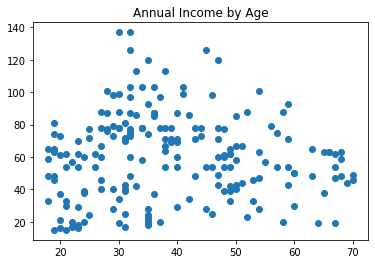

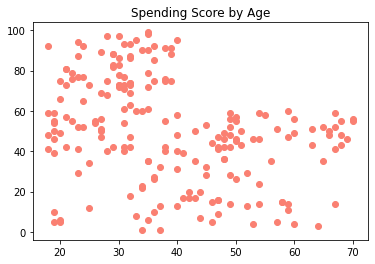

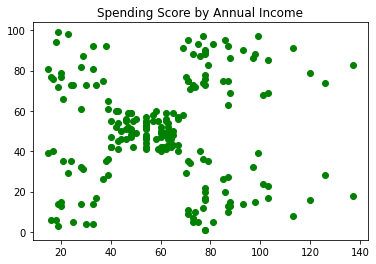

In [4]:
import matplotlib.pyplot as plt

display(customers.groupby("Gender")["Annual Income (k$)"].mean())
display(customers.groupby("Gender")["Spending Score (1-100)"].mean())

plt.figure()
plt.title("Annual Income by Age")
plt.scatter(customers["Age"], customers["Annual Income (k$)"])
plt.show()

plt.figure()
plt.title("Spending Score by Age")
plt.scatter(customers["Age"], customers["Spending Score (1-100)"], c="Salmon")
plt.show()

plt.figure()
plt.title("Spending Score by Annual Income")
plt.scatter(customers["Annual Income (k$)"], customers["Spending Score (1-100)"], c="Green")
plt.show()

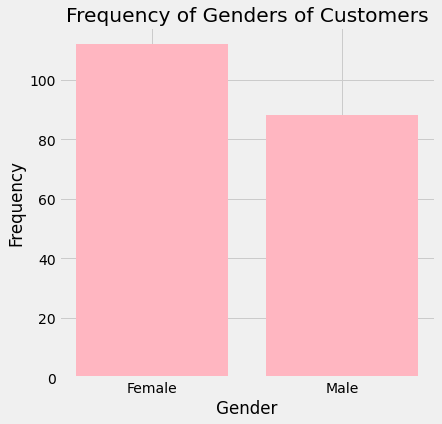

In [4]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,6))
plt.title("Frequency of Genders of Customers")
plt.bar(customers["Gender"].value_counts().index, customers["Gender"].value_counts(), color="lightpink")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.show()

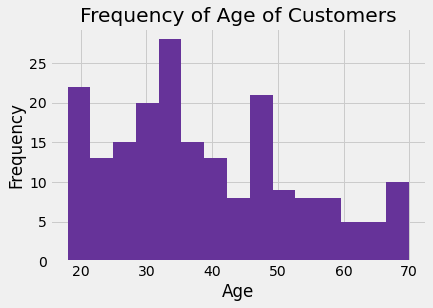

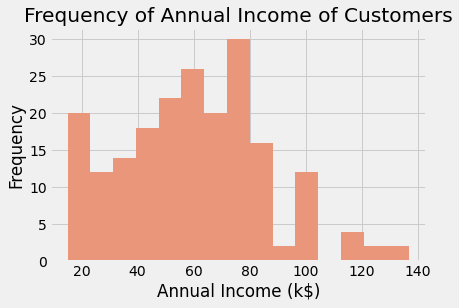

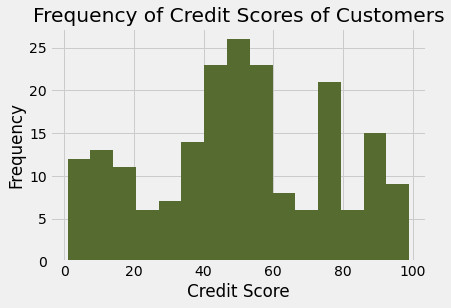

In [5]:
plt.figure()
plt.title("Frequency of Age of Customers")
plt.hist(customers["Age"], bins=15, color="rebeccapurple")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.title("Frequency of Annual Income of Customers")
plt.hist(customers["Annual Income (k$)"], bins=15, color="darksalmon")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.title("Frequency of Credit Scores of Customers")
plt.hist(customers["Spending Score (1-100)"], bins=15, color="darkolivegreen")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.show()

# Preprocess

## Encode

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
ohe = OneHotEncoder()

cat_pipe = ColumnTransformer([
    ("encode", ohe, ["Gender"])
], remainder="passthrough")

In [6]:
processed_customers = pd.DataFrame(cat_pipe.fit_transform(customers))
processed_customers.columns = ["cat_zero", "cat_one", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
display(processed_customers)

,cat_zero,cat_one,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,1.0,19.0,15.0,39.0
1,0.0,1.0,21.0,15.0,81.0
2,1.0,0.0,20.0,16.0,6.0
3,1.0,0.0,23.0,16.0,77.0
4,1.0,0.0,31.0,17.0,40.0
...,...,...,...,...,...
195,1.0,0.0,35.0,120.0,79.0
196,1.0,0.0,45.0,126.0,28.0
197,0.0,1.0,32.0,126.0,74.0
198,0.0,1.0,32.0,137.0,18.0


## Anomaly Detection

Find anomalies that we known are errors - 

In [7]:
age_errors = (list(np.array(np.where(customers["Age"]<18)).tolist()[0])
              + list(np.array(np.where(customers["Age"]>120)).tolist()[0]))
income_errors = (list(np.array(np.where(customers["Age"]<0)).tolist()[0])
                 + list(np.array(np.where(customers["Age"] > 10000)).tolist()[0]))
score_errors = (list(np.array(np.where(customers["Age"]<0)).tolist()[0])
                + list(np.array(np.where(customers["Age"] > 100)).tolist()[0]))
all_errors = age_errors + income_errors + score_errors

customers = customers.drop(index=all_errors).reset_index(drop=True)
processed_customers = processed_customers.drop(index=all_errors).reset_index(drop=True)

Find anomalies that are potentially errors - 

In [8]:
from sklearn.ensemble import IsolationForest
 
iforest = IsolationForest(contamination=0.01, n_estimators=70)
iforest.fit(processed_customers.values)
 
anom_pred = iforest.predict(processed_customers.values)
anom_index = np.where(anom_pred==-1)
anom_values = processed_customers.iloc[anom_index]

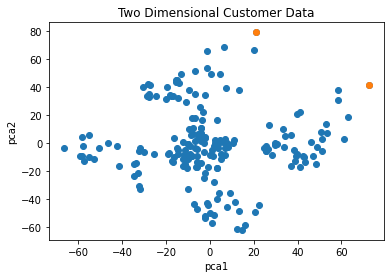

    Gender  Age  Annual Income (k$)  Spending Score (1-100)
198   Male   32                 137                      18
199   Male   30                 137                      83


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
two_dim_data = pca.fit_transform(processed_customers)

plt.title("Two Dimensional Customer Data")
plt.scatter(two_dim_data[:, 0], two_dim_data[:, 1])
plt.scatter(two_dim_data[anom_values.index, 0], two_dim_data[anom_values.index, 1])
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.show()

print(customers.iloc[anom_index])

We can't determine whether or not these observations are errors, so they won't be removed

## Scaling

In [10]:
num_pipe = ColumnTransformer([
    ("scale", scaler, ["Age", "Annual Income (k$)", "Spending Score (1-100)"]),
], remainder="passthrough")

In [11]:
processed_customers = pd.DataFrame(num_pipe.fit_transform(processed_customers))
processed_customers.columns = ["Age", "Annual Income (k$)", "Spending Score (1-100)", "cat_zero", "cat_one"]

display(processed_customers)

,Age,Annual Income (k$),Spending Score (1-100),cat_zero,cat_one
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0
...,...,...,...,...,...
195,-0.276302,2.268791,1.118061,1.0,0.0
196,0.441365,2.497807,-0.861839,1.0,0.0
197,-0.491602,2.497807,0.923953,0.0,1.0
198,-0.491602,2.917671,-1.250054,0.0,1.0


# Model

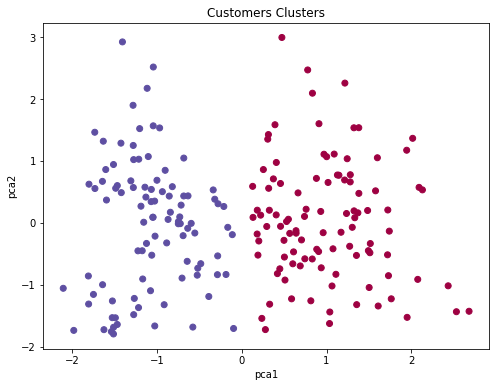

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(processed_customers)
clusters_pred = kmeans.predict(processed_customers)

processed_two_dim = pca.fit_transform(processed_customers)

plt.figure(figsize=(8,6))
plt.title("Customers Clusters")
plt.scatter(processed_two_dim[:, 0], processed_two_dim[:, 1], c=kmeans.labels_, cmap="Spectral")
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.show()

In [13]:
cluster_df = customers.copy()
cluster_df["Cluster"] = clusters_pred

test = cluster_df.groupby("Cluster")["Gender"].value_counts()
display(test)

ex = test.reset_index(level=0)
ex["Count"] = ex["Gender"]
ex = ex.drop(columns="Gender")
ex["Gender"] = ex.index.copy()
ex.index = range(len(ex))
ex = ex[["Cluster", "Gender", "Count"]]


ex

Cluster  Gender
0        Female    55
         Male      48
1        Female    57
         Male      40
Name: Gender, dtype: int64

,Cluster,Gender,Count
0,0,Female,55
1,0,Male,48
2,1,Female,57
3,1,Male,40


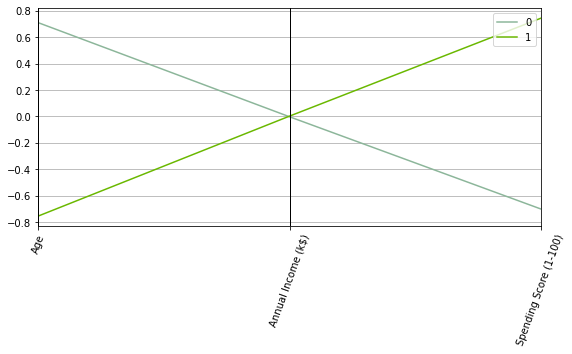

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,1
4,Female,31,17,40,1
...,...,...,...,...,...
195,Female,35,120,79,1
196,Female,45,126,28,0
197,Male,32,126,74,1
198,Male,32,137,18,0


,Age,Annual Income (k$),Spending Score (1-100),cat_zero,cat_one,Cluster
0,0.708923,-0.002475,-0.699391,0.533981,0.466019,0
1,-0.752773,0.002629,0.742652,0.587629,0.412371,1


In [14]:
from pandas.plotting import parallel_coordinates

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=processed_customers.columns)
centroids['Cluster'] = centroids.index

cluster_df = customers.copy()
cluster_df["Cluster"] = clusters_pred

plt.figure(figsize=(9, 4))
parallel_coordinates(centroids.drop(columns=["cat_zero", "cat_one"]), "Cluster")
plt.xticks(rotation=70)
plt.show()

display(cluster_df)

centroids

- Observations:
    - Cluster 0 - older customers, avg. income, lower spending score, approx. equal men and women
    - Cluster 1 - younger customers, avg. income, higher spending score, slighly more women then men